In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,0,3
1,2,upgraded card tell agent upgrade anniversary d...,3,1
2,10,chase card report however fraudulent applicati...,6,2
3,11,try book ticket come across offer apply toward...,3,3
4,14,grand son give check deposit chase account fun...,4,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,3,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,2,2
21070,78311,flawless credit chase credit card chase freedo...,7,3


# Data Partition

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(21072, 16306)

In [4]:
vectorizer.get_feature_names_out()

array(['aad', 'aba', 'abandon', ..., 'zoom', 'zur', 'zyk'], dtype=object)

In [5]:
# split into training set (test set?) and validation set

# train = 80, test = 20
# random_seed = 42
from sklearn.model_selection import train_test_split

y = df[['topic_lda','priority']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y1 = df['topic_lda']
# y2 = df['priority']

# X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# print(y1_train.shape)
# print(y1_test.shape)
# print(y2_train.shape)
# print(y2_test.shape)

(16857, 16306)
(4215, 16306)
(16857, 2)
(4215, 2)


# Model Building

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

knn = MultiOutputClassifier(KNeighborsClassifier(n_jobs=-1)).fit(X_train, y_train)

In [8]:
knn.score(X_test,y_test)

0.3758007117437722

In [9]:
knn_preds = knn.predict(X_test)

In [10]:
knn_preds

array([[0, 2],
       [5, 3],
       [1, 3],
       ...,
       [7, 3],
       [6, 3],
       [1, 2]], dtype=int64)

In [11]:
knn_preds[:, 0]

array([0, 5, 1, ..., 7, 6, 1], dtype=int64)

In [12]:
knn_preds[:, 1]

array([2, 3, 3, ..., 3, 3, 2], dtype=int64)

# Evaluation

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

================ Ticket Category =================
Accuracy:  0.6861209964412811
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.51      0.57       857
           1       0.75      0.85      0.80       463
           2       0.68      0.36      0.47       200
           3       0.64      0.78      0.71       393
           4       0.68      0.74      0.71       628
           5       0.55      0.64      0.59       281
           6       0.74      0.81      0.77       508
           7       0.70      0.76      0.73       474
           8       0.74      0.64      0.69       411

    accuracy                           0.69      4215
   macro avg       0.68      0.68      0.67      4215
weighted avg       0.69      0.69      0.68      4215



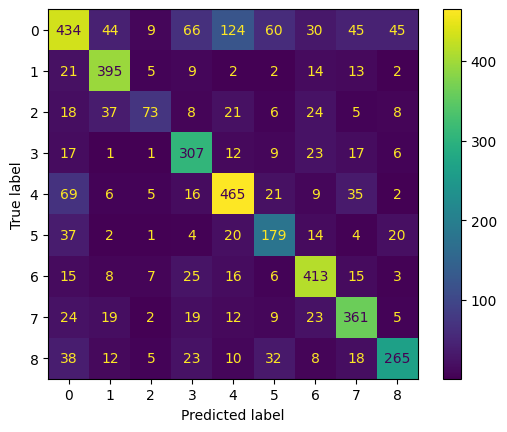

In [14]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=knn_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], knn_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=knn_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.5397390272835113
Classification Report:
               precision    recall  f1-score   support

           1       0.40      0.48      0.44       802
           2       0.42      0.30      0.35      1282
           3       0.65      0.70      0.68      2131

    accuracy                           0.54      4215
   macro avg       0.49      0.50      0.49      4215
weighted avg       0.53      0.54      0.53      4215



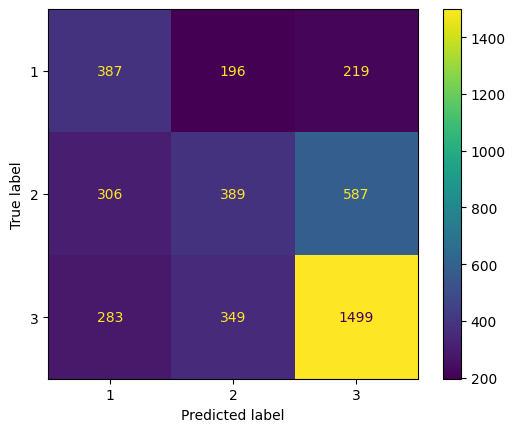

In [15]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=knn_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], knn_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=knn_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = {
    'estimator__n_neighbors': list(range(1, 10)),  # Number of neighbors
    'estimator__weights': ['uniform', 'distance']  # Weight function used in prediction
}

In [18]:
grid_search = GridSearchCV(
    estimator=MultiOutputClassifier(KNeighborsClassifier(n_jobs=-1)), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier(n_jobs=-1)),
             n_jobs=-1,
             param_grid={'estimator__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'estimator__weights': ['uniform', 'distance']},
             verbose=2)

In [20]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'estimator__n_neighbors': 9, 'estimator__weights': 'distance'}


In [21]:
bestknn = grid_search.best_estimator_

In [22]:
best_knn_score = bestknn.score(X_test, y_test)
print("Best model accuracy:", best_knn_score)

Best model accuracy: 0.41020166073546854


# Evaluation After Tuning

In [23]:
bestknn_preds = bestknn.predict(X_test)

================ Ticket Category =================
Accuracy:  0.7086595492289443
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.48      0.59       857
           1       0.76      0.87      0.81       463
           2       0.77      0.39      0.52       200
           3       0.67      0.80      0.73       393
           4       0.69      0.80      0.74       628
           5       0.58      0.70      0.63       281
           6       0.73      0.83      0.78       508
           7       0.69      0.80      0.74       474
           8       0.74      0.70      0.72       411

    accuracy                           0.71      4215
   macro avg       0.71      0.71      0.69      4215
weighted avg       0.72      0.71      0.70      4215



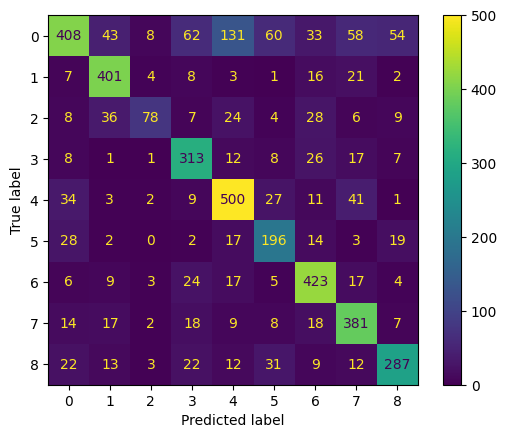

In [24]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestknn_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestknn_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestknn_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.5686832740213523
Classification Report:
               precision    recall  f1-score   support

           1       0.49      0.43      0.46       802
           2       0.46      0.28      0.34      1282
           3       0.62      0.80      0.70      2131

    accuracy                           0.57      4215
   macro avg       0.52      0.50      0.50      4215
weighted avg       0.55      0.57      0.54      4215



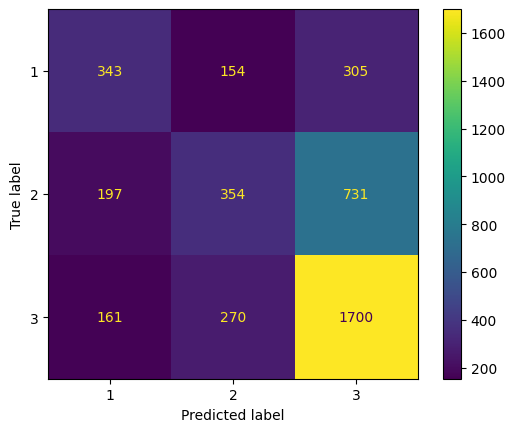

In [25]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestknn_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestknn_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestknn_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [26]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"tuned_knn.pkl"), "wb") as f:
    dump(bestknn, f, protocol=5)